# Task 8 - Find the best Random Forest through Random Search

In order to **maximize the performance of the random forest**, we can perform a **random search** for better hyperparameters. This will randomly select combinations of hyperparameters from a grid, evaluate them using cross validation on the training data, and return the values (read best model with hyperparameters) that perform the best. 

### Task Requirements
- Build a RandomForest for the above dataset (not one but many with different sets of parameters)
- Explore RandomizedSearchCV in Scikit-learn documentation
- Create a parameter grid with these values
    - n_estimators : between 10 and 200
    - max_depth : choose between 3 and 20
    - max_features : ['auto', 'sqrt', None] + list(np.arange(0.5, 1, 0.1))
    - max_leaf_nodes : choose between 10 to 50
    - min_samples_split : choose between 2, 5, or 10
    - bootstrap : choose between True or False
- Create the estimator (RandomForestClassifier)
- Create the RandomizedSearchCV with estimator, parameter grid, scoring on roc auc, n_iter = 10, random_state=RSEED(50) for same reproducible results
- Fit the model
- Explore the best model parameters
- Use the best model parameters to predict
- Plot the best model ROC AUC Curve
- Plot the Confusion Matrix
- Write any insights or observations you found in the last

## Random Forest Theory revisited

### Random Forest = Decision Tree + Bagging + Random subsets of features

The Random Forest is a model made up of many `decision trees`. Rather than just simply averaging the prediction of trees (which we could call a **forest**), this model uses two key concepts that gives it the name random:
- Random sampling of training data points when building trees
- Random subsets of features considered when splitting nodes

To be more clear, this takes the idea of a single decision tree, and creates an _ensemble_ model out of hundreds or thousands of trees to reduce the variance. 

Each tree is trained on a random set of the observations, and for each split of a node, only a `subset of the features` are used for making a split. When making predictions, the random forest `averages the predictions` for each of the individual decision trees for each data point in order to arrive at a final classification.

### Bagging

### Random sampling of training observations

- **Training**: each tree in a random forest learns from a **random sample** of the data points. The samples are drawn with replacement, known as **bootstrapping**, which means that some samples will be used multiple times in a single tree. The idea is that by training each tree on different samples, although each tree might have high variance with respect to a particular set of the training data, overall, the entire forest will have lower variance but not at the cost of increasing the bias.

- **Testing**: predictions are made by **averaging the predictions** of each decision tree. This procedure of training each individual learner on different bootstrapped subsets of the data and then averaging the predictions is known as **bagging**, short for **bootstrap aggregating**.

### Random Subsets of features for splitting nodes
Only a subset of all the features are considered for splitting each node in each decision tree. Generally this is set to `sqrt(n_features)` for classification meaning that if there are 16 features, at each node in each tree, only 4 random features will be considered for splitting the node. 

### Let us see if our theory holds good in the same dataset we used for building Decision Tree

# Behavioral Risk Factor Surveillance System

[Behavioral Risk Factor Surveillance System](https://www.kaggle.com/cdc/behavioral-risk-factor-surveillance-system)

The objective of the BRFSS is to collect uniform, state-specific data on preventive health practices and risk behaviors that are linked to chronic diseases, injuries, and preventable infectious diseases in the adult population. Factors assessed by the BRFSS include tobacco use, health care coverage, HIV/AIDS knowledge or prevention, physical activity, and fruit and vegetable consumption. Data are collected from a random sample of adults (one per household) through a telephone survey.

The Behavioral Risk Factor Surveillance System (BRFSS) is the nation's premier system of health-related telephone surveys that collect state data about U.S. residents regarding their health-related risk behaviors, chronic health conditions, and use of preventive services. Established in 1984 with 15 states, BRFSS now collects data in all 50 states as well as the District of Columbia and three U.S. territories. BRFSS completes more than 400,000 adult interviews each year, making it the largest continuously conducted health survey system in the world.

The following data set is from the Centers for Disease Control and Prevention (CDC) and includes socioeconomic and lifestyle indicators for hundreds of thousands of individuals. The objective is to predict the overall health of an individual: either 0 for poor health or 1 for good health. We'll limit the data to 100,000 individuals to speed up training.

Or, if you have the gut to take it, please pass the entire data and have fun!!!

This problem is imbalanced (far more of one label than another) so for assessing performance, we'll use recall, precision, receiver operating characteristic area under the curve (ROC AUC), and also plot the ROC curve. Accuracy is not a useful metric when dealing with an imbalanced problem. **Why????**

## Data Acquisition
Go to Kaggle Competition page and pull the dataset of 2015

Because I can't find any interesting 2015 data. So I used this information instead.
https://www.kaggle.com/competitions/spaceship-titanic/data

Spaceship Titanic
Predict which passengers are transported to an alternate dimension
Welcome to the year 2912, where your data science skills are needed to solve a cosmic mystery. We've received a transmission from four lightyears away and things aren't looking good.

The Spaceship Titanic was an interstellar passenger liner launched a month ago. With almost 13,000 passengers on board, the vessel set out on its maiden voyage transporting emigrants from our solar system to three newly habitable exoplanets orbiting nearby stars.

While rounding Alpha Centauri en route to its first destination—the torrid 55 Cancri E—the unwary Spaceship Titanic collided with a spacetime anomaly hidden within a dust cloud. Sadly, it met a similar fate as its namesake from 1000 years before. Though the ship stayed intact, almost half of the passengers were transported to an alternate dimension!

In [186]:
#1. Import Necessary Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix, classification_report
from scipy.stats import randint
RSEED=50

In [187]:
# Load the dataset and sample half of its rows
df = pd.read_csv('spaceship_titanic_data_train.csv').sample(frac=0.5, random_state=RSEED)

# 1. Inspect Missing Values
print(df.isnull().sum())

# For simplicity, let's fill missing numerical values with the median and categorical values with the mode
for column in df.columns:
    if df[column].dtype == 'object':
        df[column].fillna(df[column].mode()[0], inplace=True)
    else:
        df[column].fillna(df[column].median(), inplace=True)

# 2. Feature Engineering
# Extracting Deck from the Cabin feature
df['Deck'] = df['Cabin'].apply(lambda x: x[0])

# Extracting Side from the Cabin feature
df['Side'] = df['Cabin'].apply(lambda x: x.split('/')[-1])

# Dropping the original Cabin and Name columns as they might not be directly useful for predictions
df.drop(['Cabin', 'Name'], axis=1, inplace=True)

# 3. Encoding Categorical Variables
# Convert categorical variables using one-hot encoding
df = pd.get_dummies(df, columns=['HomePlanet', 'Destination', 'Deck', 'Side'])

# 4. Scaling is not required for Random Forest

# Display the cleaned data
df.head()


PassengerId       0
HomePlanet      102
CryoSleep       108
Cabin            96
Destination      98
Age              94
VIP             104
RoomService     103
FoodCourt        79
ShoppingMall     97
Spa              98
VRDeck           94
Name             98
Transported       0
dtype: int64


PassengerId  CryoSleep   Age    VIP  RoomService  FoodCourt  \
8059     8616_01      False  43.0  False         27.0        0.0   
2018     2154_01      False  19.0  False         78.0        0.0   
3215     3462_01       True  28.0  False          0.0        0.0   
8029     8596_01       True  44.0  False          0.0        0.0   
826      0879_01      False  46.0  False        784.0        0.0   

      ShoppingMall    Spa  VRDeck  Transported  ...  Deck_A  Deck_B  Deck_C  \
8059         797.0  830.0   161.0        False  ...       0       0       0   
2018           0.0  550.0     0.0        False  ...       0       0       0   
3215           0.0    0.0     0.0         True  ...       0       0       1   
8029           0.0    0.0     0.0         True  ...       0       0       1   
826            0.0    0.0     4.0        False  ...       0       0       0   

      Deck_D  Deck_E  Deck_F  Deck_G  Deck_T  Side_P  Side_S  
8059       0       0       1       0       0       1       0  
2018       0       0       0       1       0       1       0  
3215       0       0       0       0       0       1       0  
8029       0       0       0       0       0       1       0  
826        0       1       0       0       0       0       1  

[5 rows x 26 columns]

### Data Exploration
- Find how many features
- Find how many samples
- Find how many missing data
- Find how many categorical features
- And many more

In [188]:
df = df.select_dtypes('number')
df

Age  RoomService  FoodCourt  ShoppingMall    Spa  VRDeck  \
8059  43.0         27.0        0.0         797.0  830.0   161.0   
2018  19.0         78.0        0.0           0.0  550.0     0.0   
3215  28.0          0.0        0.0           0.0    0.0     0.0   
8029  44.0          0.0        0.0           0.0    0.0     0.0   
826   46.0        784.0        0.0           0.0    0.0     4.0   
...    ...          ...        ...           ...    ...     ...   
2643  21.0          0.0        0.0           0.0    0.0     0.0   
1526  25.0        553.0        0.0           1.0  239.0     8.0   
1026  35.0          0.0        0.0           0.0    0.0     0.0   
6630  25.0          0.0        0.0           0.0    0.0     0.0   
4801  31.0          0.0      679.0           0.0    0.0   213.0   

      HomePlanet_Earth  HomePlanet_Europa  HomePlanet_Mars  \
8059                 0                  0                1   
2018                 1                  0                0   
3215                 0                  1                0   
8029                 0                  1                0   
826                  1                  0                0   
...                ...                ...              ...   
2643                 0                  0                1   
1526                 1                  0                0   
1026                 0                  0                1   
6630                 1                  0                0   
4801                 1                  0                0   

      Destination_55 Cancri e  ...  Deck_A  Deck_B  Deck_C  Deck_D  Deck_E  \
8059                        0  ...       0       0       0       0       0   
2018                        0  ...       0       0       0       0       0   
3215                        0  ...       0       0       1       0       0   
8029                        0  ...       0       0       1       0       0   
826                         0  ...       0       0       0       0       1   
...                       ...  ...     ...     ...     ...     ...     ...   
2643                        0  ...       0       0       0       0       0   
1526                        1  ...       0       0       0       0       0   
1026                        0  ...       0       0       0       0       0   
6630                        0  ...       0       0       0       0       0   
4801                        0  ...       0       0       0       0       0   

      Deck_F  Deck_G  Deck_T  Side_P  Side_S  
8059       1       0       0       1       0  
2018       0       1       0       1       0  
3215       0       0       0       1       0  
8029       0       0       0       1       0  
826        0       0       0       0       1  
...      ...     ...     ...     ...     ...  
2643       1       0       0       1       0  
1526       1       0       0       0       1  
1026       1       0       0       1       0  
6630       0       1       0       1       0  
4801       0       1       0       0       1  

[4346 rows x 22 columns]

In [189]:
df.describe()

Age  RoomService     FoodCourt  ShoppingMall           Spa  \
count  4346.000000  4346.000000   4346.000000   4346.000000   4346.000000   
mean     28.654855   214.667050    464.539807    169.717441    322.009664   
std      14.367335   638.285643   1572.281546    639.729551   1157.463793   
min       0.000000     0.000000      0.000000      0.000000      0.000000   
25%      19.000000     0.000000      0.000000      0.000000      0.000000   
50%      27.000000     0.000000      0.000000      0.000000      0.000000   
75%      37.000000    40.000000     68.750000     20.000000     70.750000   
max      78.000000  9920.000000  29813.000000  23492.000000  18572.000000   

             VRDeck  HomePlanet_Earth  HomePlanet_Europa  HomePlanet_Mars  \
count   4346.000000       4346.000000        4346.000000      4346.000000   
mean     285.273125          0.556144           0.243212         0.200644   
std     1045.983956          0.496895           0.429072         0.400528   
min        0.000000          0.000000           0.000000         0.000000   
25%        0.000000          0.000000           0.000000         0.000000   
50%        0.000000          1.000000           0.000000         0.000000   
75%       44.000000          1.000000           0.000000         0.000000   
max    20336.000000          1.000000           1.000000         1.000000   

       Destination_55 Cancri e  ...       Deck_A       Deck_B       Deck_C  \
count              4346.000000  ...  4346.000000  4346.000000  4346.000000   
mean                  0.199034  ...     0.028992     0.086056     0.087667   
std                   0.399319  ...     0.167804     0.280479     0.282842   
min                   0.000000  ...     0.000000     0.000000     0.000000   
25%                   0.000000  ...     0.000000     0.000000     0.000000   
50%                   0.000000  ...     0.000000     0.000000     0.000000   
75%                   0.000000  ...     0.000000     0.000000     0.000000   
max                   1.000000  ...     1.000000     1.000000     1.000000   

            Deck_D       Deck_E       Deck_F       Deck_G       Deck_T  \
count  4346.000000  4346.000000  4346.000000  4346.000000  4346.000000   
mean      0.055683     0.123332     0.320985     0.297055     0.000230   
std       0.229336     0.328856     0.466909     0.457013     0.015169   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%       0.000000     0.000000     0.000000     0.000000     0.000000   
50%       0.000000     0.000000     0.000000     0.000000     0.000000   
75%       0.000000     0.000000     1.000000     1.000000     0.000000   
max       1.000000     1.000000     1.000000     1.000000     1.000000   

            Side_P       Side_S  
count  4346.000000  4346.000000  
mean      0.483203     0.516797  
std       0.499775     0.499775  
min       0.000000     0.000000  
25%       0.000000     0.000000  
50%       0.000000     1.000000  
75%       1.000000     1.000000  
max       1.000000     1.000000  

[8 rows x 22 columns]

In [190]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4346 entries, 8059 to 4801
Data columns (total 22 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Age                        4346 non-null   float64
 1   RoomService                4346 non-null   float64
 2   FoodCourt                  4346 non-null   float64
 3   ShoppingMall               4346 non-null   float64
 4   Spa                        4346 non-null   float64
 5   VRDeck                     4346 non-null   float64
 6   HomePlanet_Earth           4346 non-null   uint8  
 7   HomePlanet_Europa          4346 non-null   uint8  
 8   HomePlanet_Mars            4346 non-null   uint8  
 9   Destination_55 Cancri e    4346 non-null   uint8  
 10  Destination_PSO J318.5-22  4346 non-null   uint8  
 11  Destination_TRAPPIST-1e    4346 non-null   uint8  
 12  Deck_A                     4346 non-null   uint8  
 13  Deck_B                     4346 non-null   ui

In [191]:
# 1. Number of Features
num_features = df.shape[1]
print(f"Number of Features: {num_features}")

# 2. Number of Samples
num_samples = df.shape[0]
print(f"Number of Samples: {num_samples}")

# 3. Missing Data
missing_data = df.isnull().sum()
print("\nMissing Data for Each Feature:")
print(missing_data)

# 4. Number of Categorical Features (before filtering)

# Display the filtered dataframe
print("\nFiltered Dataframe:")
df.head()


Number of Features: 22
Number of Samples: 4346

Missing Data for Each Feature:
Age                          0
RoomService                  0
FoodCourt                    0
ShoppingMall                 0
Spa                          0
VRDeck                       0
HomePlanet_Earth             0
HomePlanet_Europa            0
HomePlanet_Mars              0
Destination_55 Cancri e      0
Destination_PSO J318.5-22    0
Destination_TRAPPIST-1e      0
Deck_A                       0
Deck_B                       0
Deck_C                       0
Deck_D                       0
Deck_E                       0
Deck_F                       0
Deck_G                       0
Deck_T                       0
Side_P                       0
Side_S                       0
dtype: int64

Filtered Dataframe:


Age  RoomService  FoodCourt  ShoppingMall    Spa  VRDeck  \
8059  43.0         27.0        0.0         797.0  830.0   161.0   
2018  19.0         78.0        0.0           0.0  550.0     0.0   
3215  28.0          0.0        0.0           0.0    0.0     0.0   
8029  44.0          0.0        0.0           0.0    0.0     0.0   
826   46.0        784.0        0.0           0.0    0.0     4.0   

      HomePlanet_Earth  HomePlanet_Europa  HomePlanet_Mars  \
8059                 0                  0                1   
2018                 1                  0                0   
3215                 0                  1                0   
8029                 0                  1                0   
826                  1                  0                0   

      Destination_55 Cancri e  ...  Deck_A  Deck_B  Deck_C  Deck_D  Deck_E  \
8059                        0  ...       0       0       0       0       0   
2018                        0  ...       0       0       0       0       0   
3215                        0  ...       0       0       1       0       0   
8029                        0  ...       0       0       1       0       0   
826                         0  ...       0       0       0       0       1   

      Deck_F  Deck_G  Deck_T  Side_P  Side_S  
8059       1       0       0       1       0  
2018       0       1       0       1       0  
3215       0       0       0       1       0  
8029       0       0       0       1       0  
826        0       0       0       0       1  

[5 rows x 22 columns]

### Label Distribution
Age is the label for this dataset

### Explore the label

### Find what are the values inside the label

In [192]:
print("Columns in the dataframe:\n")
df.columns

Columns in the dataframe:



Index(['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck',
       'HomePlanet_Earth', 'HomePlanet_Europa', 'HomePlanet_Mars',
       'Destination_55 Cancri e', 'Destination_PSO J318.5-22',
       'Destination_TRAPPIST-1e', 'Deck_A', 'Deck_B', 'Deck_C', 'Deck_D',
       'Deck_E', 'Deck_F', 'Deck_G', 'Deck_T', 'Side_P', 'Side_S'],
      dtype='object')

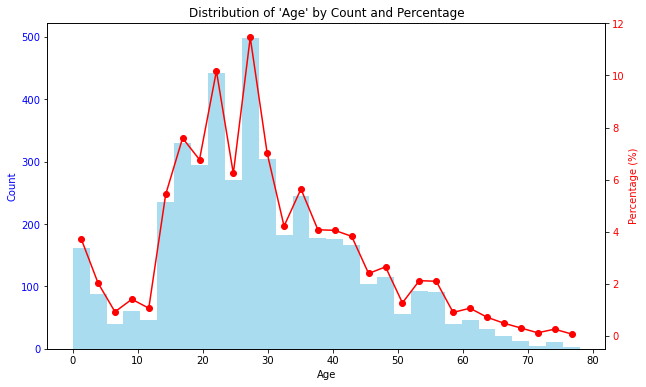

In [193]:
import seaborn as sns

# Calculate the histogram data
counts, bin_edges = np.histogram(df['Age'], bins=30)

# Calculate the percentages
percentages = counts / counts.sum() * 100

# Create the primary plot with counts
fig, ax1 = plt.subplots(figsize=(10, 6))
ax1.bar(bin_edges[:-1], counts, width=np.diff(bin_edges)[0], align="edge", color='skyblue', alpha=0.7)
ax1.set_xlabel('Age')
ax1.set_ylabel('Count', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
ax1.grid(False)

# Create the secondary y-axis for percentages
ax2 = ax1.twinx()
ax2.plot(bin_edges[:-1] + np.diff(bin_edges)[0]/2, percentages, color='red', marker='o', linestyle='-')
ax2.set_ylabel('Percentage (%)', color='red')
ax2.tick_params(axis='y', labelcolor='red')
ax2.grid(False)

# Set the title and show the plot
plt.title("Distribution of 'Age' by Count and Percentage")
plt.show()




In [194]:
df

Age  RoomService  FoodCourt  ShoppingMall    Spa  VRDeck  \
8059  43.0         27.0        0.0         797.0  830.0   161.0   
2018  19.0         78.0        0.0           0.0  550.0     0.0   
3215  28.0          0.0        0.0           0.0    0.0     0.0   
8029  44.0          0.0        0.0           0.0    0.0     0.0   
826   46.0        784.0        0.0           0.0    0.0     4.0   
...    ...          ...        ...           ...    ...     ...   
2643  21.0          0.0        0.0           0.0    0.0     0.0   
1526  25.0        553.0        0.0           1.0  239.0     8.0   
1026  35.0          0.0        0.0           0.0    0.0     0.0   
6630  25.0          0.0        0.0           0.0    0.0     0.0   
4801  31.0          0.0      679.0           0.0    0.0   213.0   

      HomePlanet_Earth  HomePlanet_Europa  HomePlanet_Mars  \
8059                 0                  0                1   
2018                 1                  0                0   
3215                 0                  1                0   
8029                 0                  1                0   
826                  1                  0                0   
...                ...                ...              ...   
2643                 0                  0                1   
1526                 1                  0                0   
1026                 0                  0                1   
6630                 1                  0                0   
4801                 1                  0                0   

      Destination_55 Cancri e  ...  Deck_A  Deck_B  Deck_C  Deck_D  Deck_E  \
8059                        0  ...       0       0       0       0       0   
2018                        0  ...       0       0       0       0       0   
3215                        0  ...       0       0       1       0       0   
8029                        0  ...       0       0       1       0       0   
826                         0  ...       0       0       0       0       1   
...                       ...  ...     ...     ...     ...     ...     ...   
2643                        0  ...       0       0       0       0       0   
1526                        1  ...       0       0       0       0       0   
1026                        0  ...       0       0       0       0       0   
6630                        0  ...       0       0       0       0       0   
4801                        0  ...       0       0       0       0       0   

      Deck_F  Deck_G  Deck_T  Side_P  Side_S  
8059       1       0       0       1       0  
2018       0       1       0       1       0  
3215       0       0       0       1       0  
8029       0       0       0       1       0  
826        0       0       0       0       1  
...      ...     ...     ...     ...     ...  
2643       1       0       0       1       0  
1526       1       0       0       0       1  
1026       1       0       0       1       0  
6630       0       1       0       1       0  
4801       0       1       0       0       1  

[4346 rows x 22 columns]

### Label feature
- Categorize passengers older than 40 as 1.0
- Categorize passengers 40 or younger as 0.0
- Rename the feature as `label`


In [195]:
# Define a threshold for age categorization
threshold_age = 40  # Example threshold

# Categorize age values based on the threshold
df['Age'] = np.where(df['Age'] > threshold_age, 1.0, 0.0)

# Rename the feature as `label`
df = df.rename(columns = {'Age': 'label'})

# Display the value counts for the new label
print(df['label'].value_counts())


0.0    3499
1.0     847
Name: label, dtype: int64


In [196]:
df

label  RoomService  FoodCourt  ShoppingMall    Spa  VRDeck  \
8059    1.0         27.0        0.0         797.0  830.0   161.0   
2018    0.0         78.0        0.0           0.0  550.0     0.0   
3215    0.0          0.0        0.0           0.0    0.0     0.0   
8029    1.0          0.0        0.0           0.0    0.0     0.0   
826     1.0        784.0        0.0           0.0    0.0     4.0   
...     ...          ...        ...           ...    ...     ...   
2643    0.0          0.0        0.0           0.0    0.0     0.0   
1526    0.0        553.0        0.0           1.0  239.0     8.0   
1026    0.0          0.0        0.0           0.0    0.0     0.0   
6630    0.0          0.0        0.0           0.0    0.0     0.0   
4801    0.0          0.0      679.0           0.0    0.0   213.0   

      HomePlanet_Earth  HomePlanet_Europa  HomePlanet_Mars  \
8059                 0                  0                1   
2018                 1                  0                0   
3215                 0                  1                0   
8029                 0                  1                0   
826                  1                  0                0   
...                ...                ...              ...   
2643                 0                  0                1   
1526                 1                  0                0   
1026                 0                  0                1   
6630                 1                  0                0   
4801                 1                  0                0   

      Destination_55 Cancri e  ...  Deck_A  Deck_B  Deck_C  Deck_D  Deck_E  \
8059                        0  ...       0       0       0       0       0   
2018                        0  ...       0       0       0       0       0   
3215                        0  ...       0       0       1       0       0   
8029                        0  ...       0       0       1       0       0   
826                         0  ...       0       0       0       0       1   
...                       ...  ...     ...     ...     ...     ...     ...   
2643                        0  ...       0       0       0       0       0   
1526                        1  ...       0       0       0       0       0   
1026                        0  ...       0       0       0       0       0   
6630                        0  ...       0       0       0       0       0   
4801                        0  ...       0       0       0       0       0   

      Deck_F  Deck_G  Deck_T  Side_P  Side_S  
8059       1       0       0       1       0  
2018       0       1       0       1       0  
3215       0       0       0       1       0  
8029       0       0       0       1       0  
826        0       0       0       0       1  
...      ...     ...     ...     ...     ...  
2643       1       0       0       1       0  
1526       1       0       0       0       1  
1026       1       0       0       1       0  
6630       0       1       0       1       0  
4801       0       1       0       0       1  

[4346 rows x 22 columns]

### What do you see?

the imbalanced distribution of the label feature, with a larger number of younger passengers (40 or below) compared to older passengers (above 40). This imbalance should be taken into consideration during any subsequent data analysis or modeling.

I'll assume you want to remove columns related to the amount billed at each of the Spaceship Titanic's amenities (e.g., 'RoomService', 'FoodCourt', etc.) as they might not be directly relevant to the age categorization.

In [197]:
# Remove selected columns
df = df.drop(columns=['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck'])

In [198]:
df

label  HomePlanet_Earth  HomePlanet_Europa  HomePlanet_Mars  \
8059    1.0                 0                  0                1   
2018    0.0                 1                  0                0   
3215    0.0                 0                  1                0   
8029    1.0                 0                  1                0   
826     1.0                 1                  0                0   
...     ...               ...                ...              ...   
2643    0.0                 0                  0                1   
1526    0.0                 1                  0                0   
1026    0.0                 0                  0                1   
6630    0.0                 1                  0                0   
4801    0.0                 1                  0                0   

      Destination_55 Cancri e  Destination_PSO J318.5-22  \
8059                        0                          0   
2018                        0                          0   
3215                        0                          0   
8029                        0                          0   
826                         0                          0   
...                       ...                        ...   
2643                        0                          0   
1526                        1                          0   
1026                        0                          0   
6630                        0                          0   
4801                        0                          0   

      Destination_TRAPPIST-1e  Deck_A  Deck_B  Deck_C  Deck_D  Deck_E  Deck_F  \
8059                        1       0       0       0       0       0       1   
2018                        1       0       0       0       0       0       0   
3215                        1       0       0       1       0       0       0   
8029                        1       0       0       1       0       0       0   
826                         1       0       0       0       0       1       0   
...                       ...     ...     ...     ...     ...     ...     ...   
2643                        1       0       0       0       0       0       1   
1526                        0       0       0       0       0       0       1   
1026                        1       0       0       0       0       0       1   
6630                        1       0       0       0       0       0       0   
4801                        1       0       0       0       0       0       0   

      Deck_G  Deck_T  Side_P  Side_S  
8059       0       0       1       0  
2018       1       0       1       0  
3215       0       0       1       0  
8029       0       0       1       0  
826        0       0       0       1  
...      ...     ...     ...     ...  
2643       0       0       1       0  
1526       0       0       0       1  
1026       0       0       1       0  
6630       1       0       1       0  
4801       1       0       0       1  

[4346 rows x 17 columns]

## Split Data into Training and Testing Set

Save 30% for testing

In [199]:
print(df.columns)


Index(['label', 'HomePlanet_Earth', 'HomePlanet_Europa', 'HomePlanet_Mars',
       'Destination_55 Cancri e', 'Destination_PSO J318.5-22',
       'Destination_TRAPPIST-1e', 'Deck_A', 'Deck_B', 'Deck_C', 'Deck_D',
       'Deck_E', 'Deck_F', 'Deck_G', 'Deck_T', 'Side_P', 'Side_S'],
      dtype='object')


In [200]:
from sklearn.model_selection import train_test_split

# Assuming 'Age' is the label you want to predict
labels = np.array(df.pop('label'))

# Splitting the data into training and testing sets
train, test, train_labels, test_labels = train_test_split(df, labels, 
                                                          stratify = labels,
                                                          test_size = 0.3, 
                                                          random_state = RSEED)


#### Imputation of Missing values

We'll fill in the missing values with the mean of the column. It's important to note that we fill in missing values in the test set with the mean of columns in the training data. This is necessary because if we get new data, we'll have to use the training data to fill in any missing values. 

In [201]:
train = train.fillna(train.mean())
test = test.fillna(train.mean())

# Features for feature importances, we will use this later below in this notebook
features = list(train.columns)

In [202]:
train.shape

(3042, 16)

In [203]:
test.shape

(1304, 16)

### Task Requirements
- Build a RandomForest for the above dataset (not one but many with different sets of parameters)
- Explore RandomizedSearchCV in Scikit-learn documentation
- Create a parameter grid with these values
    - n_estimators : between 10 and 200
    - max_depth : choose between 3 and 20
    - max_features : ['auto', 'sqrt', None] + list(np.arange(0.5, 1, 0.1))
    - max_leaf_nodes : choose between 10 to 50
    - min_samples_split : choose between 2, 5, or 10
    - bootstrap : choose between True or False
- Create the estimator (RandomForestClassifier)
- Create the RandomizedSearchCV with estimator, parameter grid, scoring on roc auc, n_iter = 10, random_state=RSEED(50) for same reproducible results
- Fit the model
- Explore the best model parameters
- Use the best model parameters to predict
- Plot the best model ROC AUC Curve
- Plot the Confusion Matrix
- Write any insights or observations you found in the last

### Import RandomizedSearchCV

In [204]:
from sklearn.model_selection import RandomizedSearchCV

### Import RandomForestClassifier

In [205]:
from sklearn.ensemble import RandomForestClassifier

### Set the parameter grid according to the requirements above as a dictionary

In [206]:
# Parameter grid
param_grid = {
    'n_estimators': np.arange(10, 201),
    'max_depth': np.arange(3, 21),
    'max_features': ['auto', 'sqrt', None] + list(np.arange(0.5, 1, 0.1)),
    'max_leaf_nodes': np.arange(10, 51),
    'min_samples_split': [2, 5, 10],
    'bootstrap': [True, False]
}

### Create the estimator with RSEED

In [207]:
# Create the estimator
rf = RandomForestClassifier(random_state=RSEED)

### Create the Random Search model with cv=3, n_iter=10, scoring='roc_auc', random_state='RSEED'

In [208]:
# Create the RandomizedSearchCV object
random_search = RandomizedSearchCV(estimator=rf, param_distributions=param_grid, 
                                   n_iter=10, scoring='roc_auc', 
                                   random_state=RSEED, cv=3, verbose=2, n_jobs=-1)

### Fit the model 
Note: It will take long time (around 20 - 1 hour depending on your computer specs). Good time to reload yourself with some energy or take a quick beauty nap!!!

In [209]:
# Fit the model
random_search.fit(train, train_labels)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(random_state=50),
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': array([ 3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19,
       20]),
                                        'max_features': ['auto', 'sqrt', None,
                                                         0.5, 0.6, 0.7,
                                                         0.7999999999999999,
                                                         0.8999999999999999],
                                        'max_leaf_nodes': array([10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23,...
       114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126,
       127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139,
       140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152,
       153, 154, 155, 156, 157, 158, 15

### Explore the best parameters

In [210]:
print("Best Parameters:", random_search.best_params_)
print("Best Score:", random_search.best_score_)

Best Parameters: {'n_estimators': 187, 'min_samples_split': 2, 'max_leaf_nodes': 12, 'max_features': 'sqrt', 'max_depth': 9, 'bootstrap': True}
Best Score: 0.5898890868530541


- First thing you'll notice is that the hyperparameter values are **not default** values.
- Awesome. You've **tuned the hyperparameters**. Well done!!!

### Use the Best Model

Choose the best model as you find in under `best_estimator_`

In [211]:
best_rf_model = random_search.best_estimator_

### Make the predictions with the chosen best model

In [212]:
# Predict the probabilities for the test set
test_probs = best_rf_model.predict_proba(test)[:, 1]

# Calculate the ROC AUC score for the test set
test_score = roc_auc_score(test_labels, test_probs)
print(f"Test ROC AUC Score: {test_score}")


Test ROC AUC Score: 0.5873378327709036


### Get the node counts and maximum depth of the random forest

In [213]:
# Initialize lists to store node counts and maximum depths for each tree
node_counts = []
max_depths = []

# Iterate through each tree in the random forest
for estimator in best_rf_model.estimators_:
    # Get the properties of the tree
    properties = estimator.tree_
    
    # Append node count and maximum depth to the respective lists
    node_counts.append(properties.node_count)
    max_depths.append(properties.max_depth)

# Print the results
print(f"Average number of nodes: {np.mean(node_counts):.2f}")
print(f"Average maximum depth: {np.mean(max_depths):.2f}")
print(f"Minimum number of nodes: {np.min(node_counts)}")
print(f"Maximum number of nodes: {np.max(node_counts)}")
print(f"Minimum maximum depth: {np.min(max_depths)}")
print(f"Maximum maximum depth: {np.max(max_depths)}")



Average number of nodes: 23.00
Average maximum depth: 6.26
Minimum number of nodes: 23
Maximum number of nodes: 23
Minimum maximum depth: 4
Maximum maximum depth: 9


In [214]:
# Print node count for each tree
for i, count in enumerate(node_counts, 1):
    print(f"Tree {i} Node Count: {count}")

Tree 1 Node Count: 23
Tree 2 Node Count: 23
Tree 3 Node Count: 23
Tree 4 Node Count: 23
Tree 5 Node Count: 23
Tree 6 Node Count: 23
Tree 7 Node Count: 23
Tree 8 Node Count: 23
Tree 9 Node Count: 23
Tree 10 Node Count: 23
Tree 11 Node Count: 23
Tree 12 Node Count: 23
Tree 13 Node Count: 23
Tree 14 Node Count: 23
Tree 15 Node Count: 23
Tree 16 Node Count: 23
Tree 17 Node Count: 23
Tree 18 Node Count: 23
Tree 19 Node Count: 23
Tree 20 Node Count: 23
Tree 21 Node Count: 23
Tree 22 Node Count: 23
Tree 23 Node Count: 23
Tree 24 Node Count: 23
Tree 25 Node Count: 23
Tree 26 Node Count: 23
Tree 27 Node Count: 23
Tree 28 Node Count: 23
Tree 29 Node Count: 23
Tree 30 Node Count: 23
Tree 31 Node Count: 23
Tree 32 Node Count: 23
Tree 33 Node Count: 23
Tree 34 Node Count: 23
Tree 35 Node Count: 23
Tree 36 Node Count: 23
Tree 37 Node Count: 23
Tree 38 Node Count: 23
Tree 39 Node Count: 23
Tree 40 Node Count: 23
Tree 41 Node Count: 23
Tree 42 Node Count: 23
Tree 43 Node Count: 23
Tree 44 Node Count: 

In [216]:
# Print maximum depth for each tree
for i, depth in enumerate(max_depths, 1):
    print(f"Tree {i} Maximum Depth: {depth}")

Tree 1 Maximum Depth: 6
Tree 2 Maximum Depth: 6
Tree 3 Maximum Depth: 8
Tree 4 Maximum Depth: 6
Tree 5 Maximum Depth: 7
Tree 6 Maximum Depth: 7
Tree 7 Maximum Depth: 7
Tree 8 Maximum Depth: 6
Tree 9 Maximum Depth: 5
Tree 10 Maximum Depth: 7
Tree 11 Maximum Depth: 6
Tree 12 Maximum Depth: 8
Tree 13 Maximum Depth: 6
Tree 14 Maximum Depth: 6
Tree 15 Maximum Depth: 7
Tree 16 Maximum Depth: 6
Tree 17 Maximum Depth: 6
Tree 18 Maximum Depth: 7
Tree 19 Maximum Depth: 5
Tree 20 Maximum Depth: 7
Tree 21 Maximum Depth: 5
Tree 22 Maximum Depth: 7
Tree 23 Maximum Depth: 7
Tree 24 Maximum Depth: 7
Tree 25 Maximum Depth: 5
Tree 26 Maximum Depth: 5
Tree 27 Maximum Depth: 5
Tree 28 Maximum Depth: 6
Tree 29 Maximum Depth: 8
Tree 30 Maximum Depth: 6
Tree 31 Maximum Depth: 6
Tree 32 Maximum Depth: 9
Tree 33 Maximum Depth: 6
Tree 34 Maximum Depth: 6
Tree 35 Maximum Depth: 6
Tree 36 Maximum Depth: 7
Tree 37 Maximum Depth: 6
Tree 38 Maximum Depth: 6
Tree 39 Maximum Depth: 8
Tree 40 Maximum Depth: 6
Tree 41 M

## Plot the ROC AUC Scores for training and testing data

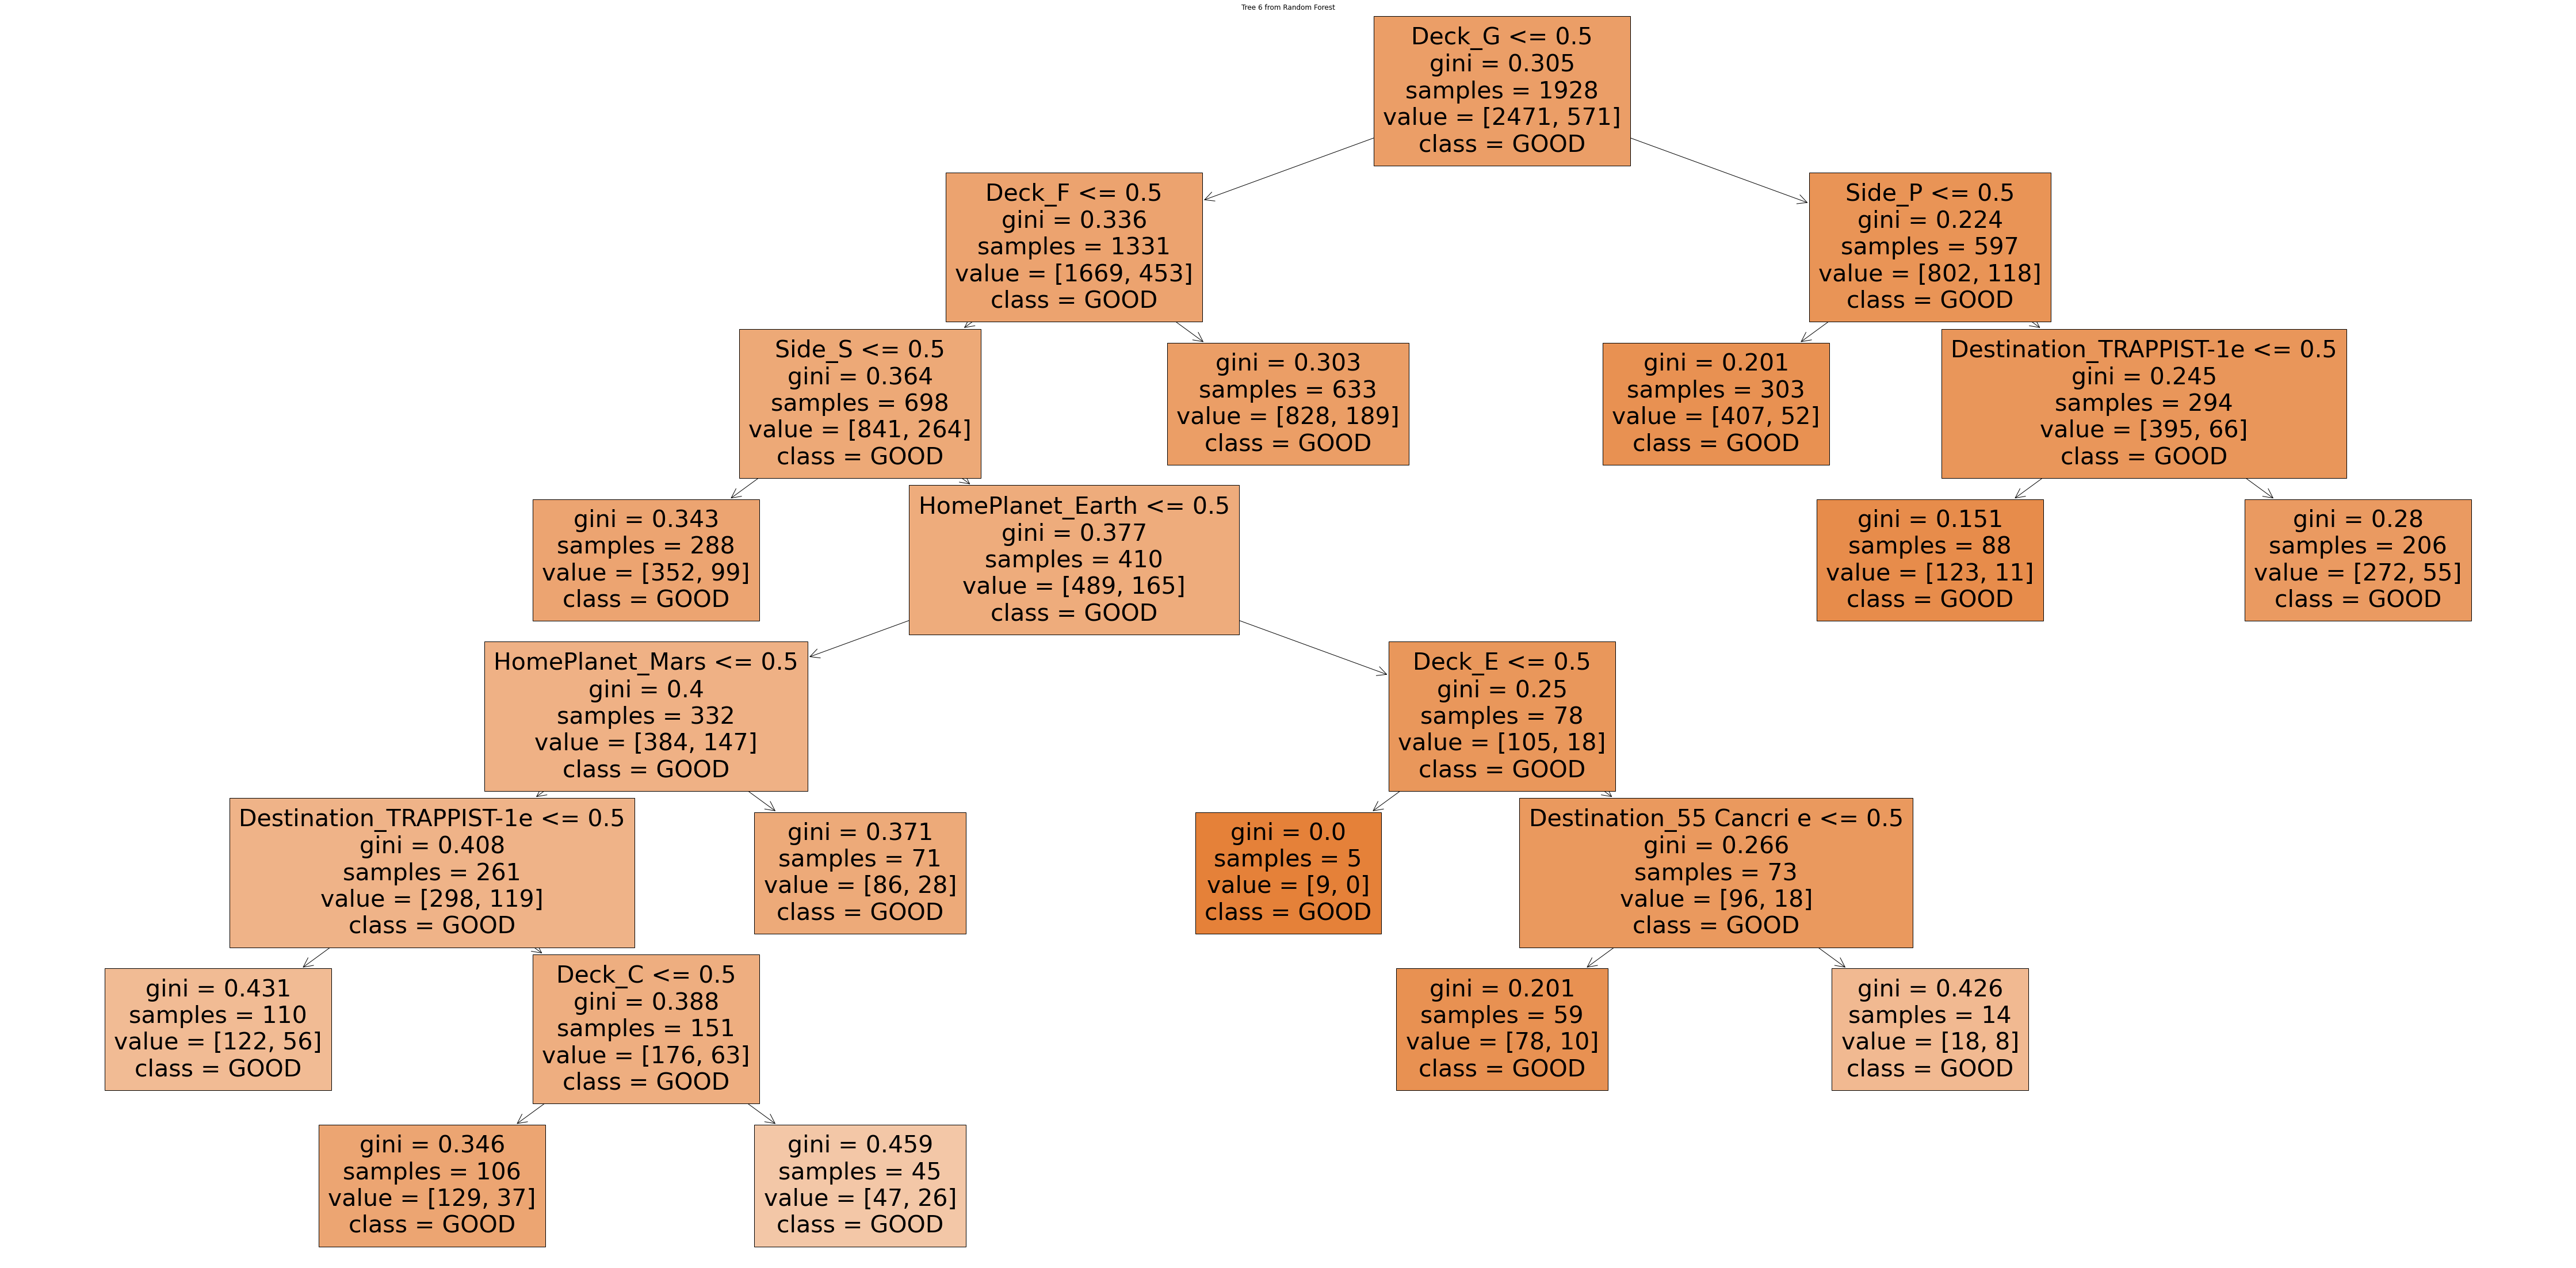

In [218]:

from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

# Plot the sixth tree
plt.figure(figsize=(80,40))
plot_tree(best_rf_model.estimators_[5], feature_names=train.columns, class_names=['GOOD', 'BAD'], filled=True)
plt.title("Tree 6 from Random Forest")
plt.show()



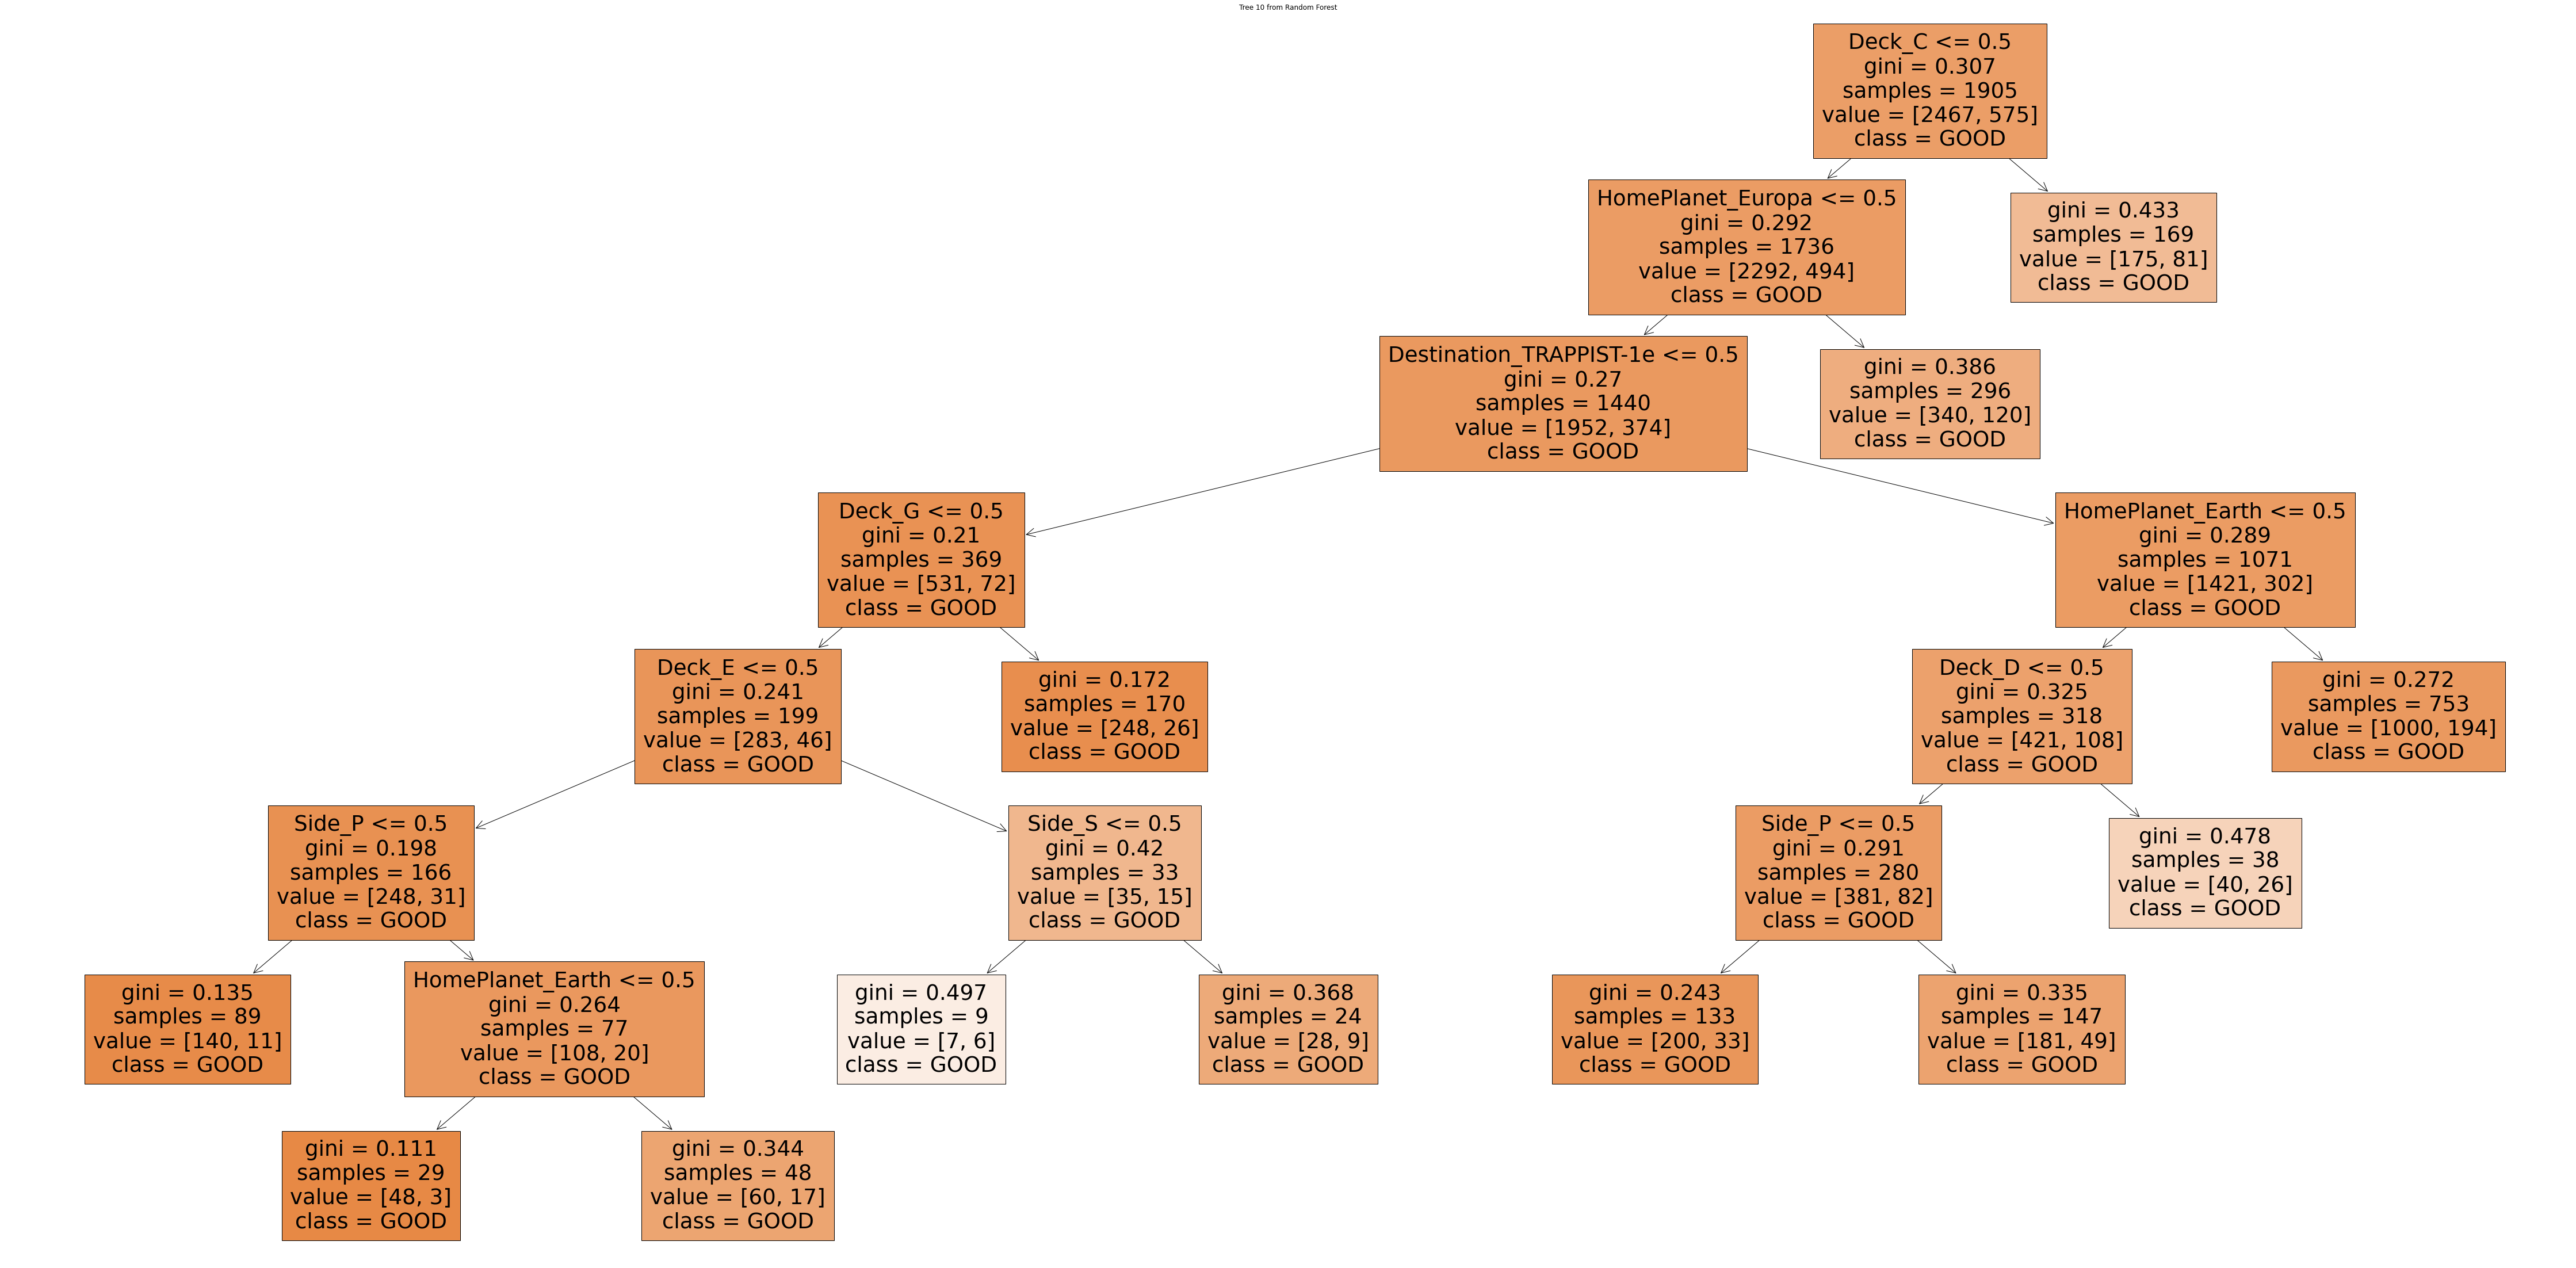

In [219]:
# Plot the tenth tree
plt.figure(figsize=(80,40))
plot_tree(best_rf_model.estimators_[9], feature_names=train.columns, class_names=['GOOD', 'BAD'], filled=True)
plt.title("Tree 10 from Random Forest")
plt.show()


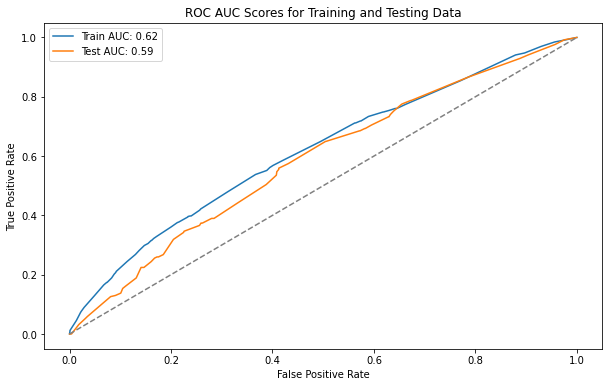

In [221]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score, recall_score, precision_score

# Predict probabilities for the training data
train_probs = best_rf_model.predict_proba(train)[:, 1]

# Calculate the ROC curve for the training data
train_fpr, train_tpr, _ = roc_curve(train_labels, train_probs)

# Calculate the AUC score for the training data
train_auc = roc_auc_score(train_labels, train_probs)

# Predict probabilities for the testing data
test_probs = best_rf_model.predict_proba(test)[:, 1]

# Calculate the ROC curve for the testing data
test_fpr, test_tpr, _ = roc_curve(test_labels, test_probs)

# Calculate the AUC score for the testing data
test_auc = roc_auc_score(test_labels, test_probs)

# Plot the ROC curves
plt.figure(figsize=(10, 6))
plt.plot(train_fpr, train_tpr, label=f"Train AUC: {train_auc:.2f}")
plt.plot(test_fpr, test_tpr, label=f"Test AUC: {test_auc:.2f}")
plt.plot([0, 1], [0, 1], color='grey', linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC AUC Scores for Training and Testing Data")
plt.legend()
plt.show()


### Helper function to Evaluate model

In [227]:
def evaluate_model(predictions, probs, train_predictions, train_probs):
    """Compare machine learning model to baseline performance.
    Computes statistics and shows ROC curve."""
    
    baseline = {}
    
    baseline['recall'] = recall_score(test_labels, [1 for _ in range(len(test_labels))])
    baseline['precision'] = precision_score(test_labels, [1 for _ in range(len(test_labels))], zero_division=1)
    baseline['roc'] = 0.5
    
    results = {}
    
    results['recall'] = recall_score(test_labels, predictions)
    results['precision'] = precision_score(test_labels, predictions, zero_division=1)
    results['roc'] = roc_auc_score(test_labels, probs)
    
    train_results = {}
    train_results['recall'] = recall_score(train_labels, train_predictions)
    train_results['precision'] = precision_score(train_labels, train_predictions, zero_division=1)
    train_results['roc'] = roc_auc_score(train_labels, train_probs)
    
    for metric in ['recall', 'precision', 'roc']:
        print(f'{metric.capitalize()} Baseline: {round(baseline[metric], 2)} Test: {round(results[metric], 2)} Train: {round(train_results[metric], 2)}')

# Get predictions and probabilities
train_predictions = best_rf_model.predict(train)
train_probs = best_rf_model.predict_proba(train)[:, 1]
predictions = best_rf_model.predict(test)
probs = best_rf_model.predict_proba(test)[:, 1]

# Evaluate the model
evaluate_model(predictions, probs, train_predictions, train_probs)


Recall Baseline: 1.0 Test: 0.0 Train: 0.0
Precision Baseline: 0.19 Test: 1.0 Train: 1.0
Roc Baseline: 0.5 Test: 0.59 Train: 0.62


### Evaluate the best model
- Plot the ROC AUC Curve

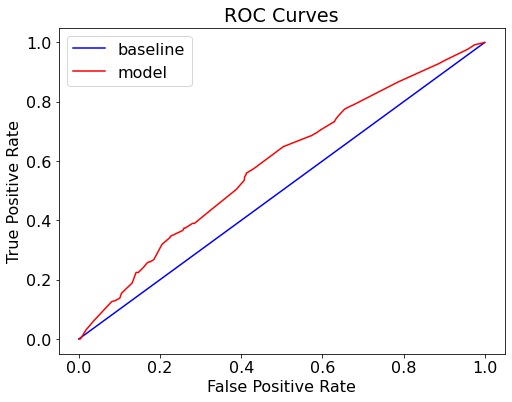

In [228]:
def plot_roc_curve():
    # Calculate false positive rates and true positive rates
    base_fpr, base_tpr, _ = roc_curve(test_labels, [1 for _ in range(len(test_labels))])
    model_fpr, model_tpr, _ = roc_curve(test_labels, probs)

    plt.figure(figsize = (8, 6))
    plt.rcParams['font.size'] = 16
    
    # Plot both curves
    plt.plot(base_fpr, base_tpr, 'b', label = 'baseline')
    plt.plot(model_fpr, model_tpr, 'r', label = 'model')
    plt.legend();
    plt.xlabel('False Positive Rate'); plt.ylabel('True Positive Rate'); plt.title('ROC Curves');
    plt.show()

plot_roc_curve()


### Confusion Matrix Helper function

Normalized confusion matrix
[[1. 0.]
 [1. 0.]]


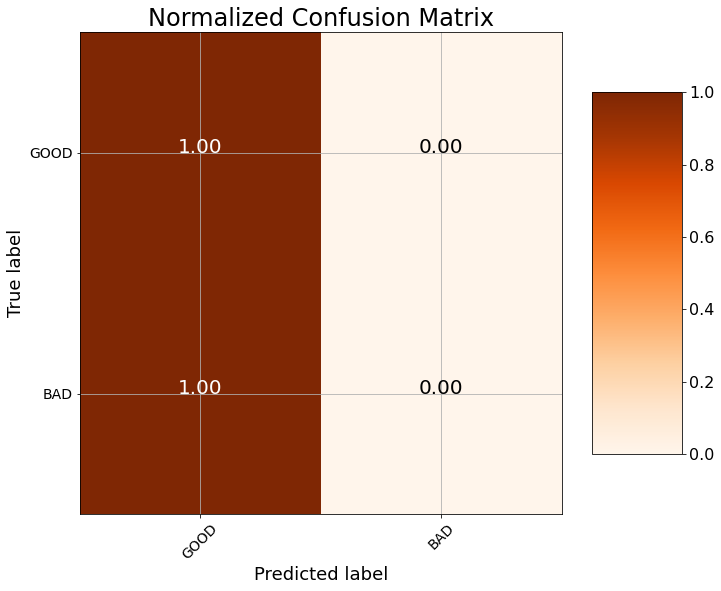

In [229]:
from sklearn.metrics import confusion_matrix
import itertools

#  Helper function to plot Confusion matrix
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Oranges):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    Source: http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.figure(figsize = (10, 10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, size = 24)
    plt.colorbar(aspect=4)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, size = 14)
    plt.yticks(tick_marks, classes, size = 14)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    
    # Labeling the plot
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), fontsize = 20,
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
        
    plt.grid(None)
    plt.tight_layout()
    plt.ylabel('True label', size = 18)
    plt.xlabel('Predicted label', size = 18)

# Compute the confusion matrix
predictions = best_rf_model.predict(test)
cm = confusion_matrix(test_labels, predictions)

# Define the class names
classes = ['GOOD', 'BAD']

# Plot the confusion matrix using the helper function
plot_confusion_matrix(cm, classes, normalize=True, title='Normalized Confusion Matrix')


# Please do not run the below 2 cells....
## It is given only for your comparision of Decision Tree, RandomForest and your very own Best RandomForest

Confusion matrix, without normalization
[[ 2677  2897]
 [ 3103 21239]]


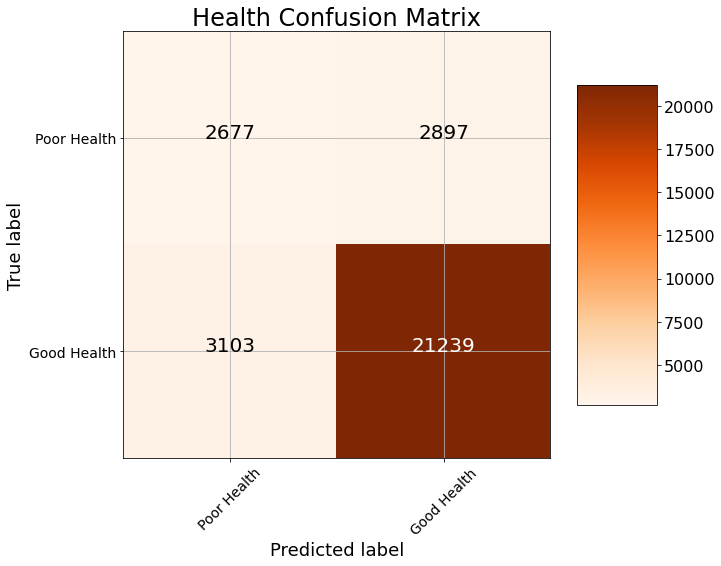

In [30]:
# Decision Tree Confusion Matrix

Confusion matrix, without normalization
[[ 2437  3137]
 [ 1011 23331]]


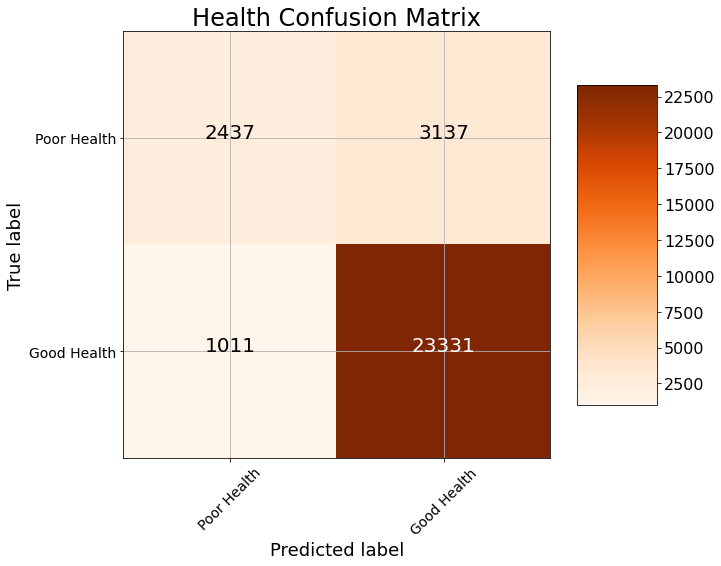

In [26]:
# Random Forest

### Evaluate the best model
- Plot Confusion Matrix

Normalized confusion matrix
[[1. 0.]
 [1. 0.]]


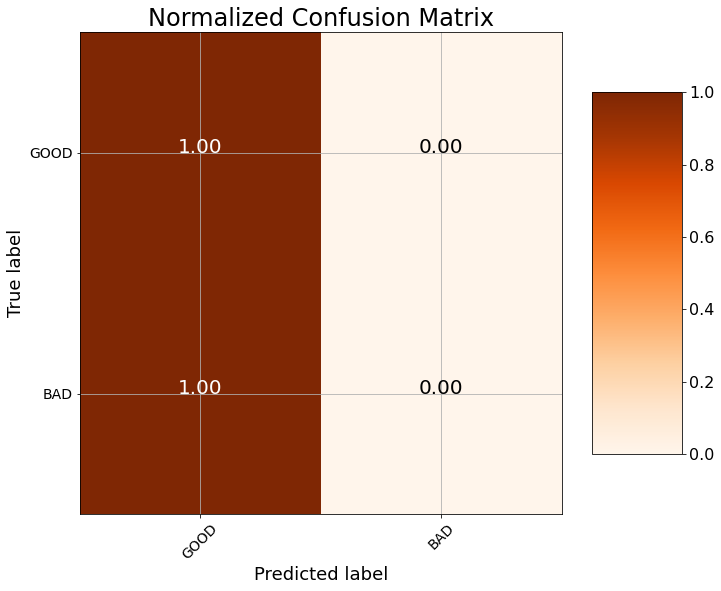

In [230]:

# Plot the confusion matrix using the helper function
plot_confusion_matrix(cm, classes, normalize=True, title='Normalized Confusion Matrix')
plt.show()


### Observations / Insights ???

Once plotted, the confusion matrix will provide a clear picture of True Positives, False Positives, True Negatives, and False Negatives. This will further confirm the model's tendency to predict one class over the other.

Confusion matrix, without normalization
[[1050    0]
 [ 254    0]]


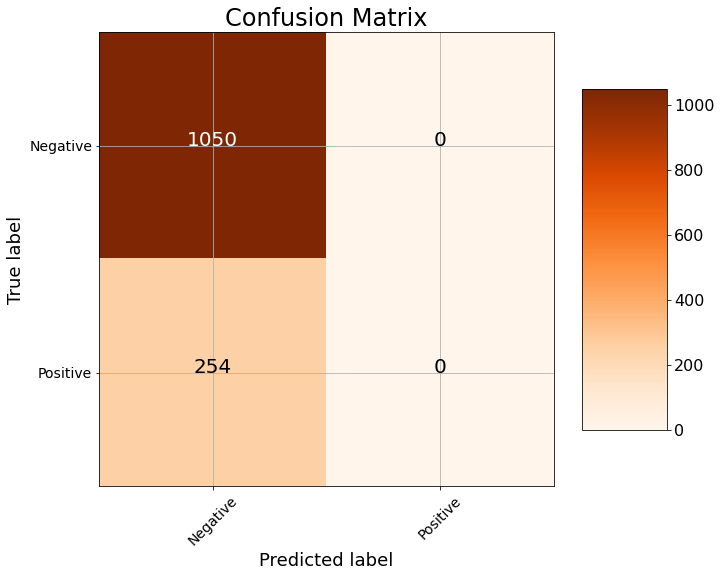

In [231]:
from sklearn.metrics import confusion_matrix

# Predict the labels for the test set
test_preds = best_rf_model.predict(test)

# Get the confusion matrix
cm = confusion_matrix(test_labels, test_preds)

# Plot the confusion matrix using the helper function
plot_confusion_matrix(cm, classes=['Negative', 'Positive'], title='Confusion Matrix')
plt.show()



1. **Confusion Matrix Components**:
   - **True Positive (TP)**: Actual positive samples that are correctly predicted as positive.
   - **True Negative (TN)**: Actual negative samples that are correctly predicted as negative.
   - **False Positive (FP)**: Actual negative samples that are incorrectly predicted as positive.
   - **False Negative (FN)**: Actual positive samples that are incorrectly predicted as negative.

2. **Interpreting the Confusion Matrix**:
   - The diagonal elements (TP and TN) represent the number of correct predictions for each class.
   - The off-diagonal elements (FP and FN) represent the mistakes made by the classifier.
   - A perfect classifier will have non-zero values only on the diagonal (no mistakes).

3. **Insights**:
   - If TP is high and FN is low, it means the model is good at identifying positive samples.
   - If TN is high and FP is low, it means the model is good at identifying negative samples.
   - A high FP means the model is classifying many negative samples as positive, leading to many false alarms.
   - A high FN means the model is missing many positive samples, which could be critical if positive identification is crucial.

4. **Metrics Derived from Confusion Matrix**:
   - **Accuracy**: `(TP + TN) / (TP + TN + FP + FN)`
   - **Precision**: `TP / (TP + FP)` - How many of the predicted positive samples are actually positive?
   - **Recall**: `TP / (TP + FN)` - How many of the actual positive samples were identified?
   - **F1-Score**: `2 * (Precision * Recall) / (Precision + Recall)` - Harmonic mean of Precision and Recall.

5. **Visual Enhancements**:
   - You can enhance the confusion matrix visualization by adding annotations for percentages or using a heatmap to represent the magnitude of each value.

Remember, while the confusion matrix provides a detailed view of the model's performance, it's essential to consider the business context. For instance, in medical diagnosis, a high FN (missing a positive case) might be more critical than a high FP (falsely identifying a negative case as positive).

### Bonus: What if you want to explain your best RandomForest to your boss on the way it split the features??? Do not fret. Capture the estimator and convert them into a .png and present it in the meeting and get accolodes.

In [31]:
from sklearn.tree import export_graphviz
from subprocess import call
from IPython.display import Image

estimator = best_model.estimators_[1]

# Export a tree from the forest
export_graphviz(estimator, 'tree_from_optimized_forest.dot', rounded = True, 
                feature_names=train.columns, max_depth = 8, 
                class_names = ['poverty', 'no poverty'], filled = True)

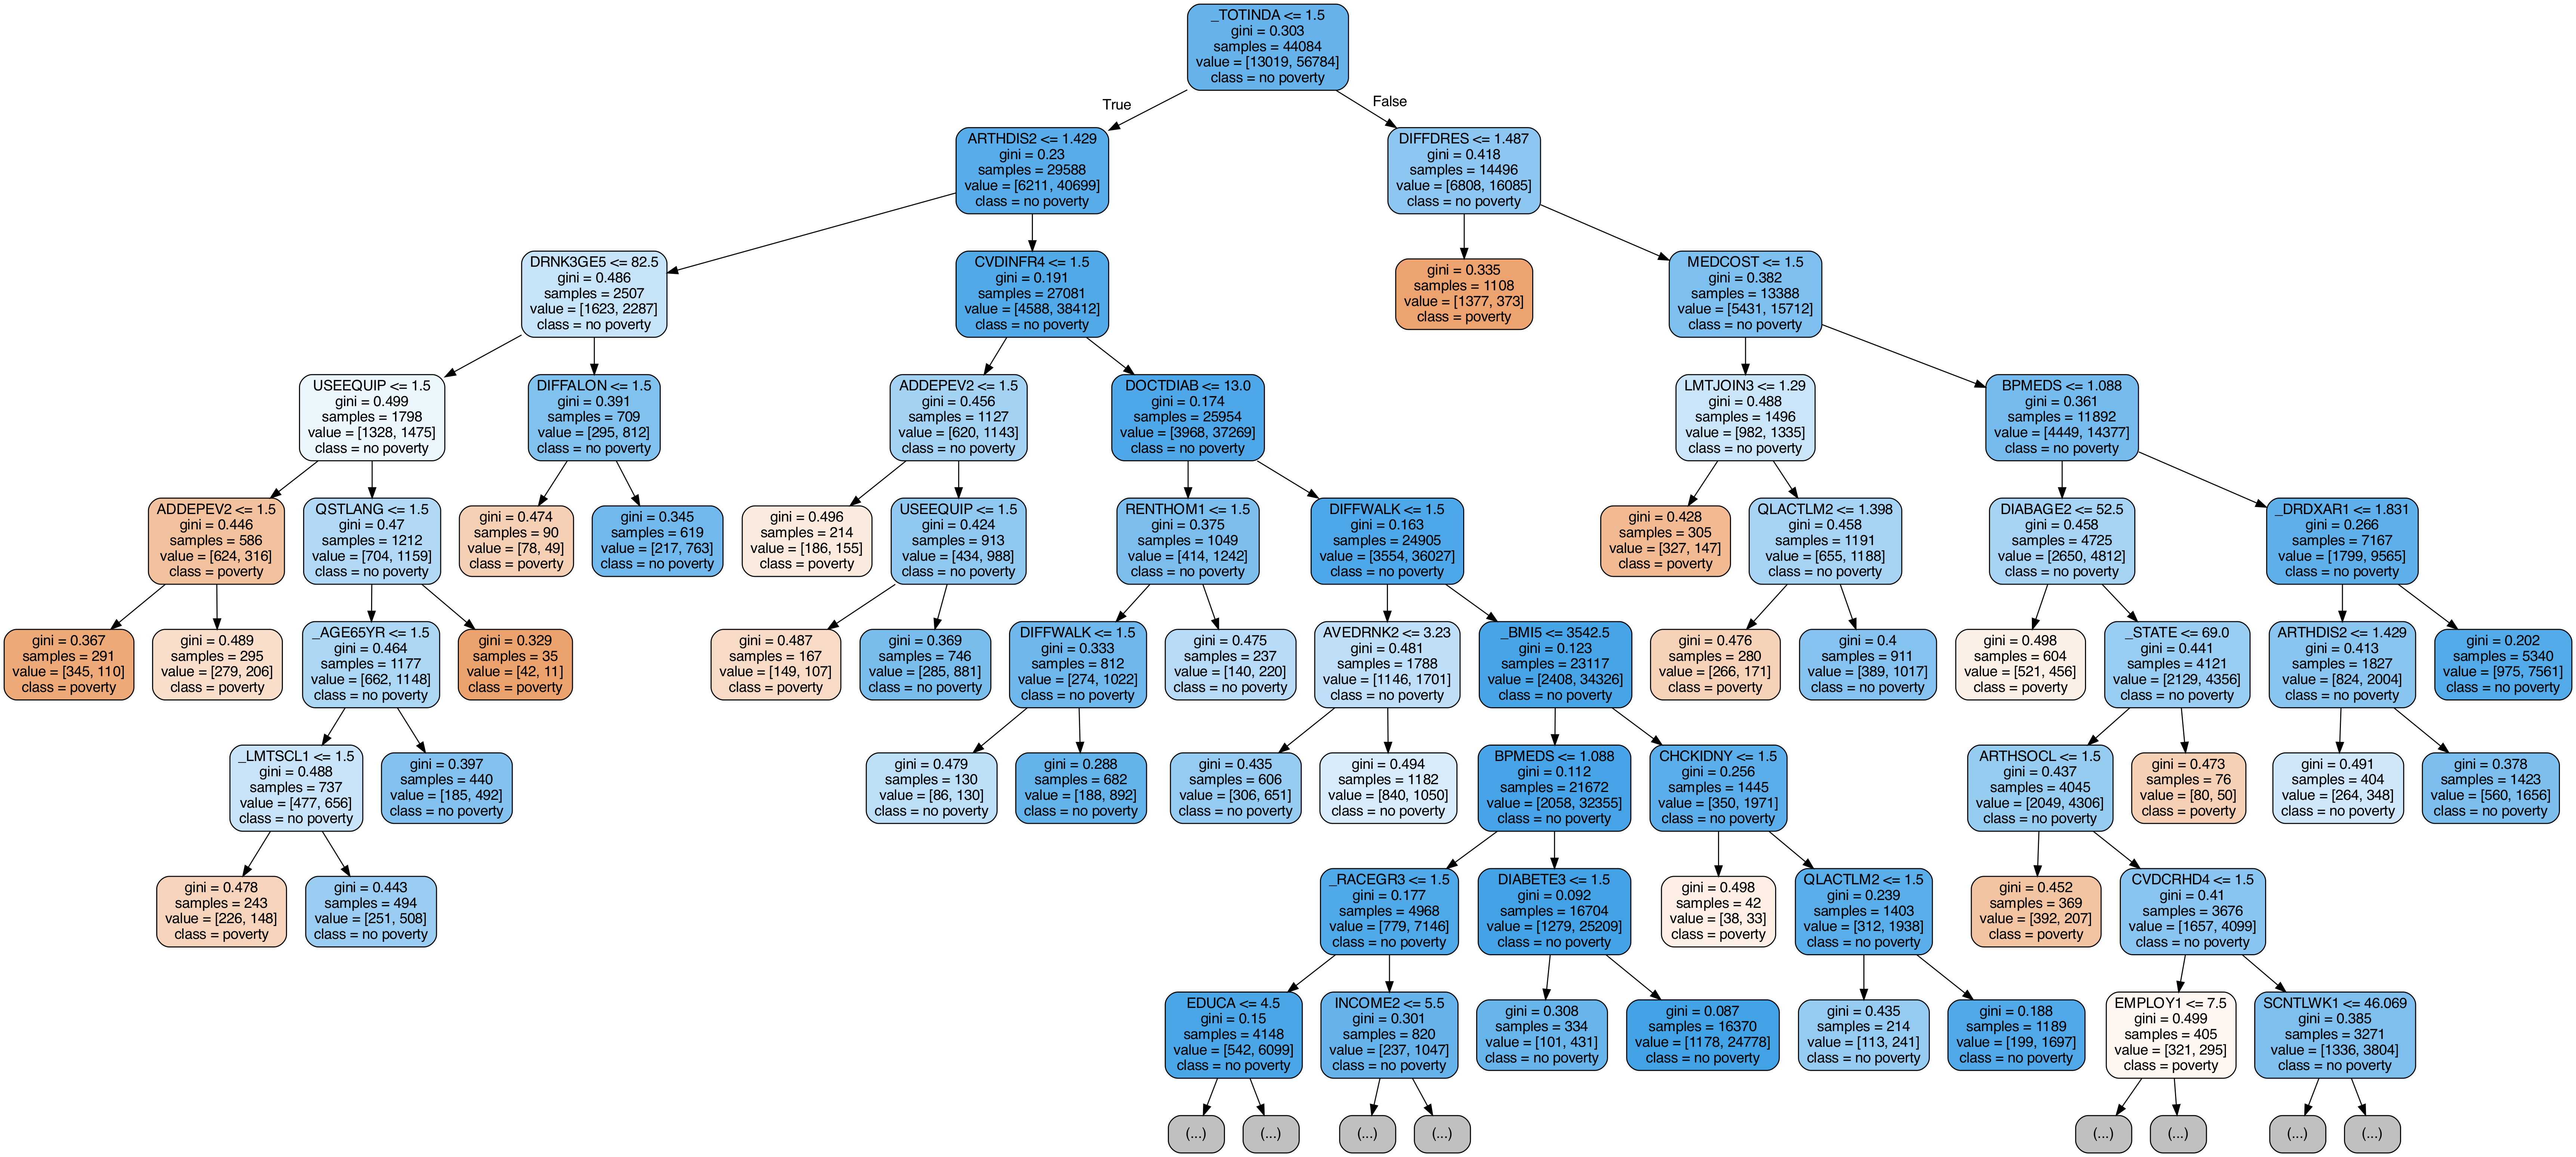

In [32]:
call(['dot', '-Tpng', 'tree_from_optimized_forest.dot', '-o', 'tree_from_optimized_forest.png', '-Gdpi=200'])
Image('tree_from_optimized_forest.png')